# MaxViT-Tiny + Metadata for CBIS-DDSM Lesion Classification

This notebook is my fourth full pipeline experiment on **classifying YOLO-cropped mammography lesions** from **CBIS-DDSM**.  
Here, I switch to a **transformer-style image backbone (MaxViT-Tiny)** and fuse it with **exam metadata** (laterality + view) to train a **single-logit malignant vs. benign classifier**.  
The notebook keeps a clean, reproducible design and pairs the model with **explainability tools (LIME + Grad-CAM++)** to check that the model focuses on lesion regions.

---

## Why this model?

- **Backbone**: `maxvit_tiny_tf_224` from `timm` is a compact transformer-based architecture with **excellent feature quality** and natural inductive bias for global/local reasoning.
- **Metadata fusion**: I concatenate a 4-dim binary vector  
  (`laterality_LEFT`, `laterality_RIGHT`, `view_CC`, `view_MLO`) to the pooled MaxViT features before the final head — a small but reliable lift for mammography data.
- **Prior-bias init**: The final layer’s bias is initialized with the **log-odds of the positive prior** on the training set, to stabilize early training under class imbalance:

  $$
  b_0 = \log\!\left(\frac{p}{1-p}\right), \qquad
  p = \frac{\#\text{malignant}}{\#\text{malignant} + \#\text{benign}}
  $$

---

## Data & Preprocessing

- **Inputs**: YOLO crops (grayscale) → converted to 3-channel RGB.
- **Transforms (train)**:
  - CLAHE for local contrast enhancement.
  - Mild brightness/contrast jitter, Gaussian blur, Gaussian noise.
  - `RandomResizedCrop` (0.9–1.0) with slight aspect ratio variation.
  - Horizontal flip (no vertical flip — preserves anatomy).
  - Mild `ShiftScaleRotate` (≤12° rotation).
  - Normalize with ImageNet mean/std.
- **Transforms (val)**: Deterministic CLAHE → Resize → Normalize.
- **Sanity checks**: Drop missing files and assert shape correctness after preprocessing.

---

## Training setup

- **Loss**: 0.5 × **Focal** + 0.5 × **BCE-with-logits**, balancing hard/easy examples:

  $$
  \mathcal{L} = \tfrac{1}{2}\,\text{BCE}(z,y) \;+\;
               \tfrac{1}{2}\,\alpha(1 - p_t)^\gamma\,\text{BCE}(z,y),
  \quad
  p_t = \sigma(z)y + (1-\sigma(z))(1-y)
  $$

- **Optimizer**: `AdamW` with weight decay \(1 \times 10^{-4}\).
- **LR schedule**: **2-epoch warmup** → **Cosine annealing** for the remaining epochs.
- **Batching**: `WeightedRandomSampler` to correct for class imbalance.
- **Precision**: AMP (mixed precision) for faster, stable training.
- **Reproducibility**: Seeded RNG for Python, NumPy, and PyTorch.

---

## Evaluation protocol

- **Metrics**:
  - ROC-AUC for ranking quality.
  - Precision–Recall AP (more informative under imbalance).
  - Threshold sweep over \(t \in [0.1, 0.9]\) to find \(t^\*\) maximizing F1.
  - Report **Balanced Accuracy**, **Sensitivity**, **Specificity**, **MCC**, and **NPV** at \(t^\*\).
- **Checkpointing**: Best model saved by validation AUC.

---

## Explainability (XAI)

- **LIME (image)**: Superpixel perturbations with **metadata held fixed** → isolates image contributions to \(p(\text{malignant})\).
- **Grad-CAM++**: Automatically finds the **last 4D feature layer** inside MaxViT, computes Grad-CAM++ maps, and overlays them on the image.

> These tools are used for **sanity checks** (e.g., heatmaps highlight the lesion area) and for FP/FN error analysis — not as ground truth.

---

## What to look for

- **ROC & PR curves**: confirm separability and clinically reasonable precision at desired recall.
- **Confusion matrix (normalized)** at tuned threshold: inspect malignant recall vs. benign false positives.
- **XAI visualizations**: ensure highlighted regions cover lesions, not borders or artifacts.

---

## Limitations & next steps

- Uses a single stratified split — future work should include **k-fold CV** or external validation.
- Could add **probability calibration** and set thresholds for fixed target sensitivity.
- Potential improvements: multi-view fusion, ConvNeXt/ViT ensembles, stronger augmentation policies.

---

## How to run

1. Set `CSV_PATH` to YOLO crops CSV and `ROOT_DIR` to dataset root.
2. Ensure GPU is available for AMP; falls back to CPU if not (slower).
3. Run cells top-to-bottom — notebook will:
   - load data & apply augmentations,
   - train MaxViT-Tiny + metadata fusion head,
   - save best checkpoint by AUC,
   - tune decision threshold for F1,
   - generate metrics, plots, and XAI visualizations.


In [1]:
# ===========================================
# Cell 1 — Setup & Imports
# ===========================================
import os, random, platform, math, logging, warnings
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix,
    classification_report, matthews_corrcoef
)

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm.auto import tqdm

warnings.filterwarnings("ignore", category=UserWarning)
logging.getLogger("timm").setLevel(logging.WARNING)

c:\Users\PC\anaconda3\envs\mammo-xai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


##  Configuration & Hyperparameters

In this cell, I define all **experiment-level settings** to make the notebook reproducible and easy to modify:

- **Dataset paths**:
  - `CSV_PATH`: Points to the CSV file containing YOLO-cropped image paths, labels, and metadata.
  - `ROOT_DIR`: Root folder of the CBIS-DDSM dataset (used to construct full file paths).

- **Training hyperparameters**:
  - `IMG_SIZE = 224`: MaxViT requires image sizes to be multiples of **28** (due to its windowed attention and downsampling).  
    For faster training I use 224, but this can be increased (e.g., 320/384) for higher-resolution evaluation.
  - `BATCH_SIZE = 16`, `EPOCHS = 15`: Standard training setup for a quick experiment.
  - `LR = 1e-4`, `WEIGHT_DECAY = 1e-4`: AdamW optimizer hyperparameters for stable convergence.
  - `OUT_PATH`: Checkpoint path where the best model (by validation AUC) will be saved.

- **Reproducibility**:
  - I seed **Python**, **NumPy**, and **PyTorch** (CPU + CUDA) RNGs with `SEED = 42` to make results deterministic.

- **Device & normalization**:
  - Automatically select **GPU** if available (falls back to CPU otherwise).
  - Define ImageNet mean/std for input normalization (matches MaxViT pretraining).

- **OS check**:
  - Detect whether running on Windows (`IS_WIN`) to adjust `num_workers` in DataLoader (avoid multiprocessing issues on Windows).

> This configuration cell acts as a **single point of control** for paths, hyperparameters, and device setup, making the notebook portable and reproducible.


In [2]:
# ===========================================
# Cell 2 — Config (fast, transformer-friendly)
# ===========================================

# --- Dataset paths ---
CSV_PATH  = r"C:\Users\PC\Desktop\final project\CBIS-DDSM\mass\data\yolo_crops.csv"  # CSV with YOLO crop paths + labels + metadata
ROOT_DIR  = r"C:\Users\PC\Desktop\final project\CBIS-DDSM\mass"                       # Root directory containing image files

# --- Core hyperparameters ---
IMG_SIZE     = 224            # Image size (must be multiple of 28 for MaxViT windowing)
BATCH_SIZE   = 16             # Mini-batch size
EPOCHS       = 15             # Number of training epochs
LR           = 1e-4           # Learning rate for AdamW optimizer
WEIGHT_DECAY = 1e-4           # L2 regularization term for optimizer
OUT_PATH     = "models/maxvit_tiny_cbis.pt"  # Path to save the best checkpoint (by AUC)

# Sanity check: MaxViT requires input size to be multiple of 28 (because of 7×7 window + 4× downsampling)
assert (IMG_SIZE % 28) == 0, "MaxViT requires IMG_SIZE to be a multiple of 28 (because window size=7 and downsample=4)"

# --- Reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# --- Device selection (GPU if available, else CPU) ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Normalization parameters (ImageNet pretraining) ---
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # mean per channel (RGB)
IMAGENET_STD  = [0.229, 0.224, 0.225]  # std per channel (RGB)

# Detect Windows OS (affects num_workers in DataLoader later)
IS_WIN = os.name == "nt" or "windows" in platform.system().lower()

print("Device:", DEVICE, "| CUDA:", torch.cuda.is_available())


Device: cuda | CUDA: True


## Data Loading & Medical-Friendly Transforms

In this cell, I handle **data ingestion**, **preprocessing**, and define a custom PyTorch `Dataset` to yield `(image, label, metadata)` triples.

---

### 1. CSV Parsing & Integrity Checks
- Load the YOLO crops CSV and verify that each file exists under `ROOT_DIR`.
- Drop missing samples to avoid runtime errors.
- Convert labels to integers (`0 = benign`, `1 = malignant`) and print dataset stats for a quick sanity check.

---

### 2. Augmentation Pipelines
- **Training pipeline** uses medically safe augmentations:
  - **CLAHE** (adaptive contrast enhancement) to emphasize local features.
  - **Brightness/contrast jitter**, **Gaussian blur/noise** for robustness to acquisition variability.
  - **RandomResizedCrop** (0.9–1.0 scale) to simulate zoom-in/out.
  - **Horizontal flip** allowed (breast left/right symmetry is acceptable).
  - **Shift/scale/rotate** with small limits (≤12°).
  - Normalize with ImageNet mean/std to match MaxViT pretraining.
- **Validation pipeline** is deterministic: CLAHE → Resize → Normalize (no randomness).

> ⚠ **Note:** If real-world inference will not use CLAHE, remove it from `val_tf` for consistency with deployment.

---

### 3. Custom Dataset Class
`CropsDataset`:
- Loads grayscale crops → stacks to 3-channel RGB.
- Applies chosen transform (`train_tf` or `val_tf`).
- Returns:
  - `x`: normalized image tensor.
  - `y`: scalar label (float32 for BCE loss).
  - `meta`: 4-dim tensor of binary metadata (`laterality_LEFT`, `laterality_RIGHT`, `view_CC`, `view_MLO`).

---

### 4. Sanity Check
- Sample one image, run through validation transforms, and assert output shape `(3, IMG_SIZE, IMG_SIZE)`.

This ensures the model will receive **properly shaped, normalized RGB tensors** with metadata ready for fusion in later cells.


In [3]:
# ===========================================
# Cell 3 — Data & Transforms (medical-friendly)
# ===========================================

# --- Load CSV containing YOLO crops, labels, and metadata ---
df = pd.read_csv(CSV_PATH)

# Check existence of each file and drop missing ones
df["exists"] = df["yolo_cropped_image_path"].apply(
    lambda rel: os.path.exists(os.path.join(ROOT_DIR, str(rel).replace("\\", os.sep)))
)
df = df[df["exists"]].copy()  # keep only rows with valid file paths

# Ensure labels are integers (0 = benign, 1 = malignant)
df["label"] = df["label"].astype(int)

# Basic dataset stats (sanity check)
print(f"Samples: {len(df)} | Malignant: {(df['label']==1).sum()} | Benign: {(df['label']==0).sum()}")

# --------------------------
# Augmentations (Training)
# --------------------------
# Build an Albumentations pipeline with:
# - CLAHE (contrast-limited adaptive histogram equalization)
# - Mild brightness/contrast jitter
# - Occasional Gaussian blur
# - Slight random crop and rescale (keeps aspect ratio close to original)
# - Horizontal flip (safe for breast imaging)
# - Small affine transforms (shift/scale/rotate)
# - Light Gaussian noise
# - Normalization with ImageNet stats
# - Convert to PyTorch tensor
train_tf = A.Compose([
    A.CLAHE(clip_limit=3.0, tile_grid_size=(8,8), p=1.0),
    A.RandomBrightnessContrast(0.15, 0.25, p=0.5),
    A.GaussianBlur(blur_limit=(3,5), p=0.10),
    A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.9, 1.0), ratio=(0.9, 1.1), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.08, rotate_limit=12,
                       border_mode=cv2.BORDER_CONSTANT, p=0.5),
    A.GaussNoise(var_limit=(5,20), p=0.10),
    A.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ToTensorV2(),
])

# --------------------------
# Validation pipeline
# --------------------------
# Deterministic: CLAHE + resize + normalize
# (CLAHE may be disabled if real-world inference uses raw images)
val_tf = A.Compose([
    A.CLAHE(clip_limit=3.0, tile_grid_size=(8,8), p=1.0),
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ToTensorV2(),
])

# --------------------------
# Dataset Class
# --------------------------
class CropsDataset(Dataset):
    def __init__(self, df, root=ROOT_DIR, tf=None):
        self.df, self.root, self.tf = df.reset_index(drop=True), root, tf

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        # Fetch row and load grayscale image
        row = self.df.iloc[i]
        p = os.path.join(self.root, str(row["yolo_cropped_image_path"]).replace("\\", os.sep))
        im = Image.open(p).convert("L")
        arr = np.array(im)

        # Convert grayscale → 3-channel RGB
        if arr.ndim == 2:
            arr = np.stack([arr, arr, arr], axis=2)

        # Apply transforms (returns torch.Tensor)
        x = self.tf(image=arr.astype(np.uint8))["image"]

        # Target label (float32 for BCE loss)
        y = torch.tensor(int(row["label"]), dtype=torch.float32)

        # Metadata vector (laterality + view) as float32 tensor
        meta = torch.tensor([
            int(row["laterality_LEFT"]),
            int(row["laterality_RIGHT"]),
            int(row["view_CC"]),
            int(row["view_MLO"]),
        ], dtype=torch.float32)

        return x, y, meta

# --------------------------
# Shape sanity check
# --------------------------
sample_p = os.path.join(ROOT_DIR, str(df.iloc[0]["yolo_cropped_image_path"]).replace("\\", os.sep))
img = Image.open(sample_p).convert("L")
arr = np.stack([np.array(img)]*3, axis=2).astype(np.uint8)
xt = val_tf(image=arr)["image"]
print("One sample tensor shape:", tuple(xt.shape))

# Assert correct tensor shape: (3, H, W)
assert xt.shape[0] == 3 and xt.shape[1] == IMG_SIZE and xt.shape[2] == IMG_SIZE, \
    "Transform shape mismatch!"


Samples: 1574 | Malignant: 775 | Benign: 799
One sample tensor shape: (3, 224, 224)


## Train/Validation Split & DataLoaders

This cell prepares the **train/validation splits** and builds the PyTorch **DataLoaders** for efficient mini-batch iteration.

---

### 1. Train/Validation Split
- **Stratified split**: Ensures malignant/benign class ratio is preserved in both train and validation sets.
- **Reproducibility**: Controlled by `random_state=SEED`.

---

### 2. Weighted Sampling
Class imbalance is handled with **WeightedRandomSampler**:
- Compute per-class counts from the training set.
- Assign **sample weights** inversely proportional to class frequency:

$$
w_c = \frac{N}{n_c}, \quad
N = \text{total samples}, \quad
n_c = \text{count for class }c
$$

- This results in approximately **balanced batches**, improving training stability and recall for the minority class.

---

### 3. DataLoader Setup
- **Training loader**: Uses weighted sampler, shuffles implicitly (through replacement sampling), and pins memory for faster host→GPU transfers.
- **Validation loader**: Uses deterministic order (`shuffle=False`) and a larger batch size (2×) to speed up evaluation.

---

### 4. Sanity Check
- Fetch one batch (`xb, yb, mb`) and verify:
  - `xb` has shape `(B, 3, IMG_SIZE, IMG_SIZE)` — correctly normalized RGB images.
  - `mb` has shape `(B, 4)` — metadata vector per sample.

>  This ensures the downstream model will receive **balanced batches** with the correct tensor dimensions, minimizing training instabilities due to class skew.


In [4]:
# ===========================================
# Cell 4 — Splits & DataLoaders
# ===========================================

# --- 1. Train/Validation Split ---
# Use stratified split to preserve class ratio between train/val
train_df, val_df = train_test_split(
    df,
    test_size=0.2,                 # 20% validation set
    stratify=df["label"],          # maintain class balance across splits
    random_state=SEED              # reproducible split
)

# Wrap into PyTorch Datasets with appropriate transforms
train_ds = CropsDataset(train_df, tf=train_tf)
val_ds   = CropsDataset(val_df, tf=val_tf)

# --- 2. Weighted Sampling for Class Imbalance ---
# Compute class counts
class_counts = Counter(train_df["label"].tolist())
# Assign weight inversely proportional to class frequency
weights = {c: len(train_df)/class_counts[c] for c in class_counts}
# Map weights to each sample
sample_weights = torch.tensor(train_df["label"].map(weights).values, dtype=torch.float32)
# Create a weighted sampler to oversample minority class
sampler = WeightedRandomSampler(
    sample_weights,
    num_samples=len(sample_weights),  # keep epoch size = dataset size
    replacement=True
)

# --- 3. DataLoaders ---
# Use fewer workers on Windows to avoid multiprocessing issues
num_workers = 0 if IS_WIN else 4

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE,
    sampler=sampler,                # use weighted sampling
    num_workers=num_workers,
    pin_memory=True                 # speeds up host→GPU transfer
)

val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE*2,
    shuffle=False,                  # deterministic validation
    num_workers=num_workers,
    pin_memory=True
)

# --- 4. Sanity Check ---
# Fetch one batch to verify shapes
xb, yb, mb = next(iter(train_loader))
print("Batch:", xb.shape, yb.shape, mb.shape)

# Ensure image and metadata shapes are correct
assert xb.shape[1:] == (3, IMG_SIZE, IMG_SIZE), "Loader image shape mismatch!"
assert mb.shape[1] == 4, "Metadata dim mismatch!"


Batch: torch.Size([16, 3, 224, 224]) torch.Size([16]) torch.Size([16, 4])


## Model Architecture — MaxViT-Tiny + Metadata Fusion

This cell defines the **model architecture** and initializes its final layer using the **training-set positive prior**.

---

### 1. Class Prior & Bias Initialization
To help the model start with a reasonable decision boundary under class imbalance, I compute the **log-odds of the positive class**:

$$
\pi = \frac{N_\text{pos}}{N_\text{pos} + N_\text{neg}}, \qquad
b_0 = \log\!\left(\frac{\pi}{1-\pi}\right)
$$

The output layer’s bias is initialized with \(b_0\), ensuring that before training, the model outputs probabilities close to the empirical class prior.  
This typically improves early training stability and speeds convergence.

---

### 2. Model Definition
- **Backbone:** `maxvit_tiny_tf_224` from `timm` with `num_classes=0` → returns a pooled feature vector \( \phi(\mathbf{x}) \in \mathbb{R}^{d} \).
- **Metadata branch:** A simple identity mapping for the 4-dim binary vector \(\mathbf{m}\).
- **Fusion head:**
  - Concatenate pooled image features and metadata: \( [\phi(\mathbf{x}) \| \mathbf{m}] \).
  - Pass through a 2-layer MLP with ReLU and dropout → produce a single logit \(z\).
  - Final prediction: $$ ( \hat{p} = \sigma(z) ). $$

$$
z = W_2 \,\mathrm{ReLU}(W_1[\phi(\mathbf{x}) \| \mathbf{m}] + b_1) + b_2, \qquad
\hat{p} = \sigma(z)
$$

---

### 3. Forward Pass Sanity Check
After instantiating the model, I run a **single forward pass** on one mini-batch to verify:
- The network executes without runtime errors.
- Output shape matches `(batch_size, 1)` as expected.
- The log message prints the computed class prior for reference.

---

>  This step completes the **model definition** stage and ensures that the model is properly configured to receive both **images** and **metadata** as inputs.


In [5]:
# ===========================================
# Cell 5 — MaxViT-Tiny + metadata fusion + prior-bias init
# ===========================================

# --- 1. Compute class prior from training set ---
pos = int((train_df["label"] == 1).sum())         # number of malignant samples
neg = int((train_df["label"] == 0).sum())         # number of benign samples
pos_prior = pos / max(1, (pos + neg))             # empirical probability of positive class
bias_init = math.log(pos_prior / max(1e-8, (1 - pos_prior)))  # log-odds (logit prior)

# --- 2. Define model architecture ---
class MaxViTTinyWithMeta(nn.Module):
    def __init__(self, meta_dim=4, dropout=0.4, prior_bias=0.0):
        super().__init__()
        # Load pretrained MaxViT-Tiny backbone, remove classification head (num_classes=0)
        # global_pool="avg" outputs a pooled feature vector of shape (B, feat_dim)
        self.base = timm.create_model(
            "maxvit_tiny_tf_224",
            pretrained=True, in_chans=3, num_classes=0, global_pool="avg"
        )
        feat_dim = self.base.num_features

        # Optional normalization for metadata (kept as Identity for binary indicators)
        self.meta_norm = nn.Identity()  # could be nn.LayerNorm(meta_dim) if features were continuous

        # Classification head: concatenate [image features | metadata] → MLP → single logit
        self.head = nn.Sequential(
            nn.Linear(feat_dim + meta_dim, 512),  # fuse image + metadata
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),                  # regularization
            nn.Linear(512, 1)                     # single output logit
        )

        # Initialize output bias to log-odds of positive class prior
        with torch.no_grad():
            self.head[-1].bias.fill_(prior_bias)

    def forward(self, x, meta):
        feats = self.base(x)                 # (B, feat_dim) from MaxViT backbone
        meta  = self.meta_norm(meta)         # (B, 4) metadata vector
        fused = torch.cat([feats, meta], 1)  # concatenate along feature dimension
        return self.head(fused)              # return logits (B, 1)

# Convenience function to create a model with prior bias
def make_model(prior_bias):
    return MaxViTTinyWithMeta(prior_bias=prior_bias)

# --- 3. Instantiate model & quick forward pass test ---
model = make_model(bias_init).to(DEVICE)
with torch.no_grad():
    out = model(xb.to(DEVICE), mb.to(DEVICE))
print("Forward OK — output:", tuple(out.shape), "| pos_prior≈", round(pos_prior, 4))


Forward OK — output: (16, 1) | pos_prior≈ 0.4925


## Optimization Setup: Loss, Optimizer, Scheduler, and AMP

This cell configures the **objective function**, **optimizer**, **learning-rate schedule**, and **automatic mixed precision (AMP)** to train the MaxViT+metadata classifier efficiently and stably.

---

### 1) Loss Function: Focal ⊕ BCE (50/50 Blend)

To handle class imbalance and focus on hard examples, I blend **Focal Loss** and **BCE-with-logits**:

- **BCE-with-logits** (numerically stable):

$$
\mathcal{L}_{\text{BCE}}(z, y) = \text{BCEWithLogits}(z, y)
$$

- **Focal Loss** (emphasizes hard samples):

$$
p = \sigma(z), \qquad
p_t = p\,y + (1-p)(1-y), \qquad
\mathcal{L}_{\text{focal}} = \alpha (1 - p_t)^\gamma \, \mathcal{L}_{\text{BCE}}
$$

where $$\alpha = 0.8$$ and $$\gamma = 2.0$$ by default.

- **Blended objective**:

$$
\mathcal{L} = 0.5 \,\mathcal{L}_{\text{focal}} + 0.5 \,\mathcal{L}_{\text{BCE}}
$$

This preserves **calibration** from BCE while improving **robustness to class imbalance** through focal reweighting.

> **Why blend?** Pure focal loss can hurt probability calibration, while pure BCE underweights rare/hard positives. This 50/50 blend strikes a practical balance.

---

### 2) Optimizer: AdamW

I use **AdamW** with:

$$
\text{LR} = 10^{-4}, \qquad
\text{Weight Decay} = 10^{-4}
$$

AdamW decouples weight decay from momentum, which stabilizes training of large vision backbones.

---

### 3) Learning-Rate Schedule: Warmup → Cosine

Two-stage LR schedule:

1. **Linear warmup** for the first $$W=2$$ epochs:

$$
\eta_t = \eta_0 \cdot \Big(0.2 + 0.8 \frac{t}{W}\Big), \qquad t \in [0, W]
$$

2. **Cosine annealing** for remaining epochs:

$$
\eta_t = \eta_{\max} \cdot \frac{1}{2} \Big(1 + \cos \Big[\pi \frac{t-W}{T-W}\Big]\Big)
$$

where $$T$$ is the total number of epochs.

This approach avoids **instability at startup** (when biases are prior-initialized) and produces a smooth convergence curve.

---

### 4) AMP (Automatic Mixed Precision)

- **`amp.autocast`** executes many operations in float16 to reduce memory footprint and speed up training.
- **`GradScaler`** dynamically scales losses to prevent underflow/overflow.

AMP typically yields **1.3×–2× speedup** on modern GPUs and allows for larger batch sizes without loss of accuracy.

---

### 5) Checkpoint Directory

Finally, I ensure that the checkpoint directory exists using:

```python
os.makedirs(os.path.dirname(OUT_PATH), exist_ok=True)


In [6]:
# ===========================================
# Cell 6 — Loss, Optimizer, Scheduler (AMP-safe)
# ===========================================

def focal_loss(inputs, targets, alpha=0.8, gamma=2.0, reduction='mean'):
    """
    Focal loss for binary classification with logits.
    - inputs : raw logits of shape (B, 1)
    - targets: ground-truth in {0,1} with shape (B, 1)
    - alpha  : class weighting factor (down-weights easy negatives if <1)
    - gamma  : focusing parameter (emphasizes hard misclassified examples)
    Returns a scalar loss (mean or sum).
    """
    # Stable BCE on logits; no sigmoid inside BCE to avoid numerical issues
    bce = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

    # Convert logits → probabilities in (0,1)
    probs = torch.sigmoid(inputs)

    # p_t = p   if y=1, else = 1-p; standard focal-loss notation
    p_t = probs * targets + (1 - probs) * (1 - targets)

    # Focal factor shrinks gradients for well-classified examples
    loss = (alpha * (1 - p_t) ** gamma) * bce
    return loss.mean() if reduction == 'mean' else loss.sum()


# Blend focal + BCE to balance robustness (focal) and calibration (BCE)
criterion = lambda logits, y: 0.5 * focal_loss(logits, y) + \
                              0.5 * nn.functional.binary_cross_entropy_with_logits(logits, y)

# AdamW optimizer (decoupled weight decay) — good default for vision backbones
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
WARMUP_EPOCHS = 2

# Two-stage LR schedule:
#   1) Linear warmup from 0.2×LR → 1.0×LR over first WARMUP_EPOCHS
#   2) Cosine annealing for the remaining epochs
scheduler = SequentialLR(
    optimizer,
    schedulers=[
        LinearLR(optimizer, start_factor=0.2, end_factor=1.0, total_iters=WARMUP_EPOCHS),
        CosineAnnealingLR(optimizer, T_max=max(1, EPOCHS - WARMUP_EPOCHS))
    ],
    milestones=[WARMUP_EPOCHS]
)

# --- Automatic Mixed Precision (AMP) setup ---
from torch import amp
use_cuda = DEVICE.type == "cuda"

# GradScaler prevents underflow/overflow when using float16 on GPU
scaler = amp.GradScaler(enabled=use_cuda)

# Autocast runs selected ops in lower precision for speed; safe on CUDA
autocast_ctx = amp.autocast(device_type="cuda", enabled=use_cuda)

# Ensure directory for checkpoints exists (avoid runtime errors on save)
os.makedirs(os.path.dirname(OUT_PATH), exist_ok=True)


## Evaluation Utilities

This cell defines helper functions for **model evaluation** on the validation set.

---

### 1) `evaluate` Function

- **Purpose:** Runs inference on an entire `DataLoader` and computes key performance metrics.
- **Steps:**
  1. Set model to `eval()` mode (disables dropout & batchnorm updates).
  2. Iterate over batches, move inputs/labels/metadata to the correct device.
  3. Collect:
     - $$\hat{p} = \sigma(z)$$ — predicted probability of malignancy.
     - $$y_{\text{true}} \in \{0,1\}$$ — ground truth labels.
  4. Threshold probabilities at $$0.5$$ to get hard predictions:
     
     $$
     y_{\text{pred}} = \begin{cases}
     1, & \hat{p} \geq 0.5 \\
     0, & \hat{p} < 0.5
     \end{cases}
     $$

  5. Compute:
     - **Accuracy**: $$\text{Acc} = \frac{TP+TN}{TP+TN+FP+FN}$$
     - **F1 Score**: $$F_1 = \frac{2 \cdot \text{Precision} \cdot \text{Recall}}
                                    {\text{Precision} + \text{Recall}}$$
     - **ROC-AUC**: threshold-free measure of ranking quality.

Returns:  
`acc, f1, auc, (y_true, y_prob, y_pred)`

---

### 2) `print_val_report`

A small wrapper that:
- Calls `evaluate`
- Prints results in a compact line:



In [7]:
# ===========================================
# Cell 7 — Evaluation utilities
# ===========================================

@torch.no_grad()
def evaluate(model, loader, device=DEVICE):
    """
    Runs inference on the entire loader and computes key metrics:
    - Accuracy
    - F1-score (binary, threshold=0.5)
    - ROC-AUC (threshold-free)
    Returns:
        acc, f1, auc, (y_true, y_prob, y_pred)
    """
    model.eval()  # switch to inference mode (disable dropout/BN updates)

    y_true, y_prob = [], []
    for x, y, m in loader:
        # Move data to device (GPU/CPU)
        x, y, m = x.to(device), y.to(device), m.to(device)
        logits = model(x, m)  # forward pass

        # Convert logits → probabilities (malignancy probability)
        probs = torch.sigmoid(logits).squeeze(1).cpu().numpy()

        # Accumulate results
        y_prob.extend(probs)
        y_true.extend(y.cpu().numpy())

    # Threshold at 0.5 for hard predictions
    y_pred = [1 if p >= 0.5 else 0 for p in y_prob]

    # Compute metrics
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    return acc, f1, auc, (y_true, y_prob, y_pred)


def print_val_report(model, loader, title="Validation @0.5"):
    """
    Convenience function to run evaluation and print a concise report.
    """
    acc, f1, auc, _ = evaluate(model, loader)
    print(f"{title}: acc={acc:.4f} | f1={f1:.4f} | auc={auc:.4f}")
    return auc


# Quick sanity check with randomly initialized weights
print_val_report(model, val_loader, title="Sanity check (random weights)")


Sanity check (random weights): acc=0.4603 | f1=0.5596 | auc=0.4531


0.45306451612903226

## Training Loop, Validation, and Checkpointing

This cell performs one full **optimization epoch**, reports **validation metrics**, advances the **learning-rate schedule**, and **checkpoints** the best model by **ROC–AUC**.

---

### 1) Mini-batch Training with AMP

Each iteration executes:

1. **Forward** in mixed precision:
   - Compute logits $$z = f(\mathbf{x}, \mathbf{m}) \in \mathbb{R}^{B \times 1}$$ under `autocast`.
2. **Loss** (from Cell 6):
   - Blended objective  
     $$
     \mathcal{L} = 0.5\,\mathcal{L}_{\text{focal}} + 0.5\,\mathcal{L}_{\text{BCE}}
     $$
3. **Backward + Step**:
   - On CUDA, use `GradScaler` to scale/unscale the loss and update the optimizer stably in fp16.
4. **Progress logging**:
   - `tqdm` shows current batch loss and the **instantaneous LR**.

AMP reduces memory bandwidth and typically yields a **1.3–2×** speedup without harming accuracy.

---

### 2) Epoch Loss

The epoch training loss is the sample-weighted mean:

$$
\overline{\mathcal{L}}_{\text{train}} = \frac{1}{N}\sum_{i=1}^{N} \mathcal{L}^{(i)}
$$

We accumulate `total_loss += \mathcal{L} \times \text{batch\_size}` and divide by the number of seen samples.

---

### 3) Validation & AUC-based Model Selection

After each epoch, I evaluate at a fixed threshold $$0.5$$ for **accuracy** and **F1**, and compute **ROC–AUC** using the raw probabilities:

- **Hard predictions** (for reporting):
  $$
  \hat{y} = \mathbb{1}\{\sigma(z) \ge 0.5\}
  $$
- **AUC** (threshold-free): measures ranking quality and is robust under class imbalance.

**Checkpointing criterion**:
$$
\text{save\_model} \iff \text{AUC}_{\text{epoch}} > \text{AUC}_{\text{best}}
$$

This avoids dependence on a particular threshold early in training.

---

### 4) Learning-Rate Scheduling

At the end of each epoch, I call `scheduler.step()` to transition from **linear warmup** to **cosine annealing** (configured in Cell 6):

- Warmup for the first $$W=2$$ epochs.
- Cosine decay for the remaining $$T-W$$ epochs:
  $$
  \eta_t = \eta_{\max}\cdot \tfrac{1}{2}\Big(1 + \cos\big(\pi \tfrac{t-W}{T-W}\big)\Big)
  $$

---



In [8]:
# ===========================================
# Cell 8 — Training Loop (tqdm + epoch logs)
# ===========================================

best_auc, history = -1.0, []  # track the best AUC for checkpointing + per-epoch logs

for epoch in range(1, EPOCHS+1):
    model.train()                 # enable dropout/BN updates
    total_loss, n = 0.0, 0        # running loss (for epoch avg)

    # tqdm progress bar over training mini-batches
    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d}", leave=True)
    for x, y, m in pbar:
        # move batch to device; y -> (B,1) to match logits shape
        x, y, m = x.to(DEVICE), y.to(DEVICE).unsqueeze(1), m.to(DEVICE)

        # zero grads; set_to_none avoids unnecessary memory writes
        optimizer.zero_grad(set_to_none=True)

        # mixed-precision forward + loss for speed on CUDA
        with autocast_ctx:
            logits = model(x, m)          # forward pass: (B,1) logits
            loss = criterion(logits, y)   # blended focal+BCE (Cell 6)

        if use_cuda:
            # scale loss to prevent underflow, then backward
            scaler.scale(loss).backward()
            # Optional stability (commented): unscale + grad clipping
            # scaler.unscale_(optimizer); torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)        # step with scaled grads
            scaler.update()               # update scale for next iter
        else:
            loss.backward()
            # Optional grad clipping for CPU/full precision:
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # bookkeeping for running-mean loss and live progress
        bs = x.size(0)
        total_loss += loss.item() * bs
        n += bs
        pbar.set_postfix({"loss": f"{loss.item():.4f}",
                          "lr": f"{optimizer.param_groups[0]['lr']:.1e}"})

    # epoch aggregates
    tr_loss = total_loss / max(1, n)

    # quick validation readout at fixed threshold 0.5 (rank metric AUC is threshold-free)
    auc_epoch = print_val_report(model, val_loader, title=f"Epoch {epoch:02d} val @0.5")

    # advance LR schedule (warmup → cosine)
    scheduler.step()

    # log history for later plotting
    history.append({"epoch": epoch, "loss": tr_loss, "auc": auc_epoch})

    # checkpoint the best AUC (threshold-free selection)
    if auc_epoch > best_auc:
        best_auc = auc_epoch
        torch.save({"model": model.state_dict()}, OUT_PATH)
        print(f"  ↳ New best AUC {best_auc:.4f} — checkpoint saved to {OUT_PATH}")

# summary after training
print("Best AUC during training:", best_auc)


Epoch 01: 100%|██████████| 79/79 [00:19<00:00,  4.16it/s, loss=0.4172, lr=2.0e-05]


Epoch 01 val @0.5: acc=0.5905 | f1=0.4603 | auc=0.6465
  ↳ New best AUC 0.6465 — checkpoint saved to models/maxvit_tiny_cbis.pt


Epoch 02: 100%|██████████| 79/79 [00:18<00:00,  4.23it/s, loss=0.2633, lr=6.0e-05]


Epoch 02 val @0.5: acc=0.6444 | f1=0.6818 | auc=0.7407
  ↳ New best AUC 0.7407 — checkpoint saved to models/maxvit_tiny_cbis.pt


Epoch 03: 100%|██████████| 79/79 [00:18<00:00,  4.29it/s, loss=0.3811, lr=1.0e-04]


Epoch 03 val @0.5: acc=0.6127 | f1=0.3776 | auc=0.7448
  ↳ New best AUC 0.7448 — checkpoint saved to models/maxvit_tiny_cbis.pt


Epoch 04: 100%|██████████| 79/79 [00:18<00:00,  4.24it/s, loss=0.3217, lr=9.9e-05]


Epoch 04 val @0.5: acc=0.6825 | f1=0.7191 | auc=0.7904
  ↳ New best AUC 0.7904 — checkpoint saved to models/maxvit_tiny_cbis.pt


Epoch 05: 100%|██████████| 79/79 [00:18<00:00,  4.28it/s, loss=0.2282, lr=9.4e-05]


Epoch 05 val @0.5: acc=0.6984 | f1=0.6619 | auc=0.7503


Epoch 06: 100%|██████████| 79/79 [00:18<00:00,  4.29it/s, loss=0.3657, lr=8.7e-05]


Epoch 06 val @0.5: acc=0.7079 | f1=0.6406 | auc=0.7831


Epoch 07: 100%|██████████| 79/79 [00:18<00:00,  4.27it/s, loss=0.3051, lr=7.8e-05]


Epoch 07 val @0.5: acc=0.6254 | f1=0.6685 | auc=0.7572


Epoch 08: 100%|██████████| 79/79 [00:18<00:00,  4.31it/s, loss=0.1519, lr=6.8e-05]


Epoch 08 val @0.5: acc=0.7238 | f1=0.6904 | auc=0.7983
  ↳ New best AUC 0.7983 — checkpoint saved to models/maxvit_tiny_cbis.pt


Epoch 09: 100%|██████████| 79/79 [00:18<00:00,  4.29it/s, loss=0.1219, lr=5.6e-05]


Epoch 09 val @0.5: acc=0.7333 | f1=0.7143 | auc=0.8036
  ↳ New best AUC 0.8036 — checkpoint saved to models/maxvit_tiny_cbis.pt


Epoch 10: 100%|██████████| 79/79 [00:18<00:00,  4.31it/s, loss=0.1689, lr=4.4e-05]


Epoch 10 val @0.5: acc=0.7079 | f1=0.7089 | auc=0.8005


Epoch 11: 100%|██████████| 79/79 [00:18<00:00,  4.29it/s, loss=0.0796, lr=3.2e-05]


Epoch 11 val @0.5: acc=0.7143 | f1=0.7078 | auc=0.7992


Epoch 12: 100%|██████████| 79/79 [00:18<00:00,  4.29it/s, loss=0.1903, lr=2.2e-05]


Epoch 12 val @0.5: acc=0.7111 | f1=0.6957 | auc=0.7882


Epoch 13: 100%|██████████| 79/79 [00:18<00:00,  4.30it/s, loss=0.0244, lr=1.3e-05]


Epoch 13 val @0.5: acc=0.7333 | f1=0.7181 | auc=0.7932


Epoch 14: 100%|██████████| 79/79 [00:18<00:00,  4.24it/s, loss=0.1347, lr=5.7e-06]


Epoch 14 val @0.5: acc=0.7175 | f1=0.7043 | auc=0.7953


Epoch 15: 100%|██████████| 79/79 [00:18<00:00,  4.27it/s, loss=0.0418, lr=1.5e-06]


Epoch 15 val @0.5: acc=0.7111 | f1=0.6977 | auc=0.7798
Best AUC during training: 0.8035887096774192


## Final Validation & Threshold Tuning

I reload the **best AUC checkpoint**, evaluate at the default threshold $$0.5$$, then **tune the decision threshold** to maximize **F1** on the validation set.

---

### 1) Load Best Checkpoint
Restore the model saved with the highest ROC–AUC during training and switch to `eval()`.

---

### 2) Baseline at $$0.5$$
Hard predictions at the default cutoff:
$$
\hat{y} = \mathbb{1}\{\hat{p} \ge 0.5\}, \qquad \hat{p} = \sigma(z).
$$
AUC is threshold-free and reflects ranking quality.

---

### 3) Threshold Tuning for F1
Sweep thresholds and pick
$$
t^{\ast} \;=\; \operatorname*{arg\,max}_{\,t \in [0.1,\,0.9]}\; F_{1}(t),
\qquad
\hat{y}(t) = \mathbb{1}\{\hat{p} \ge t\}.
$$

The **F1 score**:
$$
F_{1} \;=\; \frac{2 \cdot \text{Precision} \cdot \text{Recall}}
{\text{Precision} + \text{Recall}}.
$$

---

### 4) Metrics at $$t^{\ast}$$
From the confusion matrix
$$
\begin{bmatrix}
TN & FP\\
FN & TP
\end{bmatrix},
$$
I compute:
$$
\text{Sensitivity} = \frac{TP}{TP + FN}, \qquad
\text{Specificity} = \frac{TN}{TN + FP},
$$
$$
\text{Precision} = \frac{TP}{TP + FP}, \qquad
\text{NPV} = \frac{TN}{TN + FN},
$$
$$
\text{BAcc} = \tfrac{1}{2}\,(\text{Sensitivity} + \text{Specificity}),
$$
$$
\text{MCC} =
\frac{TP \cdot TN - FP \cdot FN}
{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}.
$$

I also report **AUC** alongside these tuned-threshold metrics.

---

### 5) Diagnostic Tables
- **Confusion matrix** at $$t^{\ast}$$ clarifies the trade-off between malignant recall and benign false positives.
- **Classification report** shows per-class precision/recall/F1.

---



In [9]:
# ===========================================
# Cell 9 — Final Validation & Threshold Tuning
# ===========================================

# --- 1) Load best checkpoint (selected by AUC during training) ---
ckpt = torch.load(OUT_PATH, map_location=DEVICE)
model_best = make_model(bias_init).to(DEVICE)
model_best.load_state_dict(ckpt["model"])
model_best.eval()

# --- 2) Evaluate best model at the default threshold 0.5 ---
acc, f1, auc, (y_true, y_prob, y_pred) = evaluate(model_best, val_loader)
print(f"Best ckpt @0.5 — acc={acc:.4f}, f1={f1:.4f}, auc={auc:.4f}")

# --- 3) Tune decision threshold t to maximize F1 on the validation set ---
best_t, best_f1 = 0.5, f1
for t in np.linspace(0.1, 0.9, 50):     # coarse sweep; can refine if needed
    yp = [1 if p >= t else 0 for p in y_prob]
    f1_t = f1_score(y_true, yp)
    if f1_t > best_f1:
        best_f1, best_t = f1_t, t

# --- 4) Compute confusion-matrix–derived metrics at the tuned threshold t* ---
yp_opt = [1 if p >= best_t else 0 for p in y_prob]
cm = confusion_matrix(y_true, yp_opt)
tn, fp, fn, tp = cm.ravel()

# Core operating characteristics
sensitivity   = tp / (tp + fn + 1e-8)  # recall for positive (malignant) class
specificity   = tn / (tn + fp + 1e-8)  # recall for negative (benign) class
precision     = tp / (tp + fp + 1e-8)  # PPV
npv           = tn / (tn + fn + 1e-8)  # NPV
balanced_acc  = 0.5 * (sensitivity + specificity)
mcc           = matthews_corrcoef(y_true, yp_opt)

# --- 5) Report metrics at tuned threshold and print diagnostic tables ---
print("\n=== Metrics at optimal threshold ===")
print(f"Threshold        : {best_t:.3f}")
print(f"Accuracy         : {accuracy_score(y_true, yp_opt):.4f}")
print(f"Balanced Acc     : {balanced_acc:.4f}")
print(f"Sensitivity      : {sensitivity:.4f}")
print(f"Specificity      : {specificity:.4f}")
print(f"Precision        : {precision:.4f}")
print(f"NPV              : {npv:.4f}")
print(f"F1 Score         : {best_f1:.4f}")
print(f"AUC              : {roc_auc_score(y_true, y_prob):.4f}")
print(f"MCC              : {mcc:.4f}")
print("\nConfusion matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, yp_opt, target_names=['benign','malignant']))


C:\Users\PC\AppData\Local\Temp\ipykernel_18244\525280430.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(OUT_PATH, map_location=DEVICE)


Best ckpt @0.5 — acc=0.7587, f1=0.7450, auc=0.8109

=== Metrics at optimal threshold ===
Threshold        : 0.500
Accuracy         : 0.7587
Balanced Acc     : 0.7581
Sensitivity      : 0.7161
Specificity      : 0.8000
Precision        : 0.7762
NPV              : 0.7442
F1 Score         : 0.7450
AUC              : 0.8109
MCC              : 0.5183

Confusion matrix:
 [[128  32]
 [ 44 111]]

Classification Report:
               precision    recall  f1-score   support

      benign       0.74      0.80      0.77       160
   malignant       0.78      0.72      0.74       155

    accuracy                           0.76       315
   macro avg       0.76      0.76      0.76       315
weighted avg       0.76      0.76      0.76       315



## Performance Visualizations

This cell summarizes validation performance with **threshold-free curves**, the **tuned operating point** $$t^{\ast}$$, and **at-a-glance** plots.

---

### 1) ROC Curve
We plot the Receiver Operating Characteristic and display the AUC:
$$
\text{AUC} = \int_{0}^{1} \text{TPR}(\text{FPR})\, d\,\text{FPR}.
$$
The highlighted point is the model’s operating point at $$t^{\ast}$$ with
$$
\text{TPR}(t^{\ast}) = \frac{TP}{TP+FN}, \qquad
\text{FPR}(t^{\ast}) = \frac{FP}{FP+TN}.
$$

---

### 2) Precision–Recall Curve
Given class imbalance, PR is often more informative than ROC. We show the **Average Precision (AP)**:
$$
\text{AP} = \sum_{k} \big( R_{k} - R_{k-1} \big)\, P_{k},
$$
where $$P_k$$ and $$R_k$$ are precision and recall at successive thresholds.  
The marker indicates $$(\text{Recall}, \text{Precision})$$ at $$t^{\ast}$$.

---

### 3) F1 vs. Threshold
We sweep thresholds $$t \in [0,1]$$ and plot
$$
F_{1}(t) = \frac{2 \cdot \text{Precision}(t) \cdot \text{Recall}(t)}
{\text{Precision}(t) + \text{Recall}(t)}.
$$
The dashed line marks $$t^{\ast}$$ (the maximizer found in Cell 9).

---

### 4) Confusion Matrix (Normalized @ $$t^{\ast}$$)
Row-normalized matrix
$$
\begin{bmatrix}
TN & FP\\
FN & TP
\end{bmatrix}
\quad\to\quad
\begin{bmatrix}
\frac{TN}{TN+FP} & \frac{FP}{TN+FP}\\[4pt]
\frac{FN}{FN+TP} & \frac{TP}{FN+TP}
\end{bmatrix}
$$
so each row sums to 1. This emphasizes **per-class recall** (malignant vs. benign).

---

### 5) Metric Bar Chart at $$t^{\ast}$$
We display:
- **Accuracy**, **Balanced Acc** $$= \tfrac{1}{2}(\text{Sensitivity} + \text{Specificity})$$
- **Sensitivity (TPR)**, **Specificity (TNR)**
- **Precision (PPV)**, **NPV**
- **F1**
- **MCC**:
$$
\text{MCC} =
\frac{TP \cdot TN - FP \cdot FN}
{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}.
$$

---

### Interpretation Tips
- **ROC vs. PR**: AUC is threshold-free; AP reflects performance on the positive (malignant) class under imbalance.
- **Operating point**: Use $$t^{\ast}$$ for balanced F1, or choose $$t$$ to meet a **target sensitivity** and report the induced specificity/PPV.
- **Confusion matrix**: Check whether errors are mostly **FP** (over-calling malignancy) or **FN** (missed malignancy) and adjust threshold accordingly.


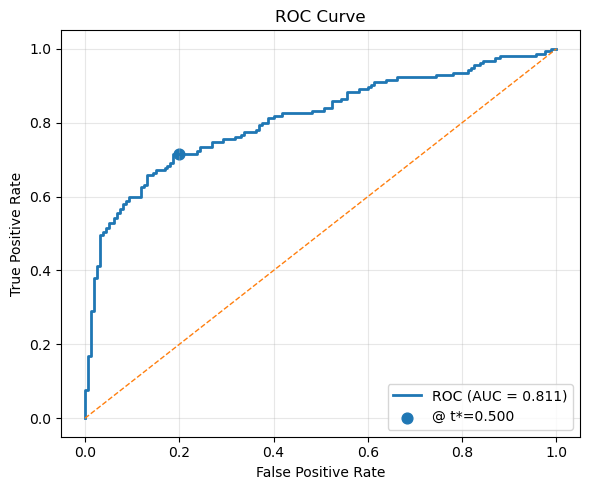

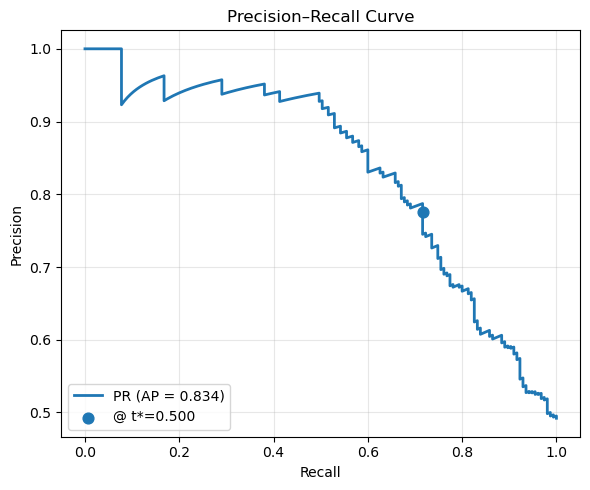

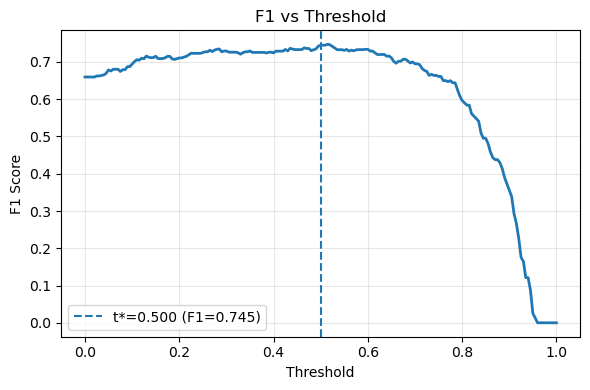

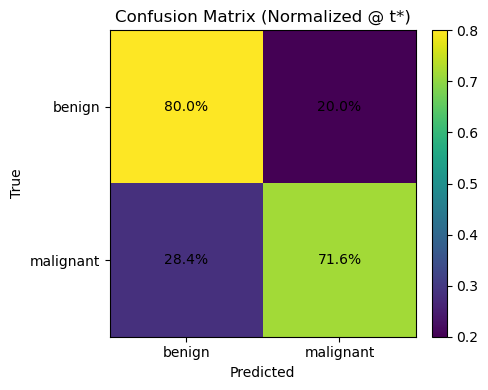

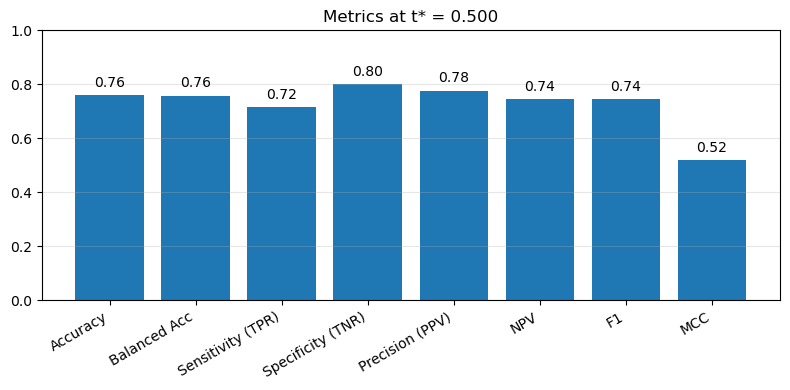

In [10]:
# ===========================================
# Cell 10 — Performance Visualizations
# ===========================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score

# --- Safety: ensure required vars from Cell 9 exist
assert 'y_true' in globals() and 'y_prob' in globals(), "Run Cell 9 first to compute y_true/y_prob."
assert 'best_t' in globals() and 'best_f1' in globals(), "Run Cell 9 first to tune threshold."
assert 'cm' in globals(), "Run Cell 9 first to compute confusion matrix."
assert 'balanced_acc' in globals() and 'sensitivity' in globals() and 'specificity' in globals(), "Run Cell 9 first."

# --- Curves (threshold-free summaries) ---
# ROC and PR data from validation scores
fpr, tpr, _ = roc_curve(y_true, y_prob)                     # false/true positive rates across thresholds
prec, rec, _ = precision_recall_curve(y_true, y_prob)       # precision/recall across thresholds
ap = average_precision_score(y_true, y_prob)                 # area under PR curve (average precision)

# --- Operating point at tuned threshold t* ---
yp_opt = [1 if p >= best_t else 0 for p in y_prob]          # hard predictions at tuned threshold
tn, fp, fn, tp = cm.ravel()
tpr_op = tp / (tp + fn + 1e-8)                              # recall at t*
fpr_op = fp / (fp + tn + 1e-8)                              # false positive rate at t*
prec_op = tp / (tp + fp + 1e-8)                             # precision at t*
rec_op  = tpr_op                                            # recall equals TPR

# --- F1 vs threshold curve (for visual sanity check of t*) ---
ts = np.linspace(0.0, 1.0, 201)
f1s = []
for t in ts:
    yp = [1 if p >= t else 0 for p in y_prob]
    # robust F1 with tiny epsilon to avoid zero-division
    tp_ = sum((np.array(y_true) == 1) & (np.array(yp) == 1))
    fp_ = sum((np.array(y_true) == 0) & (np.array(yp) == 1))
    fn_ = sum((np.array(y_true) == 1) & (np.array(yp) == 0))
    f1s.append((2 * tp_) / (2 * tp_ + fp_ + fn_ + 1e-8))
f1s = np.array(f1s)

# --- Normalized confusion matrix (row-wise) at t* ---
cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-8)

# --- Metric vector at t* (for bar chart) ---
from sklearn.metrics import accuracy_score, roc_auc_score
acc_t = accuracy_score(y_true, yp_opt)
metrics_labels = [
    "Accuracy", "Balanced Acc", "Sensitivity (TPR)", "Specificity (TNR)",
    "Precision (PPV)", "NPV", "F1", "MCC"
]
metrics_values = [acc_t, balanced_acc, sensitivity, specificity, precision, npv, best_f1, mcc]

# -------------------- PLOTS --------------------
# 1) ROC
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC = {roc_auc_score(y_true, y_prob):.3f})")
plt.scatter([fpr_op], [tpr_op], s=60, marker='o', label=f"@ t*={best_t:.3f}")  # operating point
plt.plot([0,1], [0,1], '--', lw=1)  # chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Precision–Recall
plt.figure(figsize=(6,5))
plt.plot(rec, prec, lw=2, label=f"PR (AP = {ap:.3f})")
plt.scatter([rec_op], [prec_op], s=60, marker='o', label=f"@ t*={best_t:.3f}")  # operating point
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3) F1 vs Threshold
plt.figure(figsize=(6,4))
plt.plot(ts, f1s, lw=2)
plt.axvline(best_t, linestyle='--', label=f"t*={best_t:.3f} (F1={best_f1:.3f})")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 vs Threshold")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4) Confusion matrix heatmap (normalized, no seaborn)
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm_norm, interpolation='nearest')
ax.set_title("Confusion Matrix (Normalized @ t*)")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["benign", "malignant"]); ax.set_yticklabels(["benign", "malignant"])
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
# annotate cells with percentages
for i in range(2):
    for j in range(2):
        ax.text(j, i, f"{cm_norm[i, j]*100:.1f}%", ha="center", va="center")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# 5) Metric bar chart at t*
plt.figure(figsize=(8,4))
plt.bar(range(len(metrics_values)), metrics_values)
plt.xticks(range(len(metrics_labels)), metrics_labels, rotation=30, ha='right')
plt.ylim(0, 1.0)
plt.title(f"Metrics at t* = {best_t:.3f}")
# annotate bars with values
for i, v in enumerate(metrics_values):
    plt.text(i, v + 0.02 if v < 0.95 else v - 0.06, f"{v:.2f}", ha='center', va='bottom')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [11]:
# ===========================================
# Cell 11 — XAI Helpers (SHAP & LIME)  (robust indices)
# Works with your MaxViTTinyWithMeta (model_best) that takes (x, meta)->logit
# ===========================================

import numpy as np
import torch
import torch.nn as nn

# --- NumPy 2.0 compatibility shim for older SHAP versions ---
if not hasattr(np, "obj2sctype"):
    np.obj2sctype = lambda obj: np.dtype(obj).type  # minimal compatibility shim

import shap
from lime import lime_image
from skimage.segmentation import slic
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Ensure inference-only behavior (no dropout/bn updates).
model_best.eval()

# --- Build a 4-dim metadata tensor from a DataFrame row ---
# Order matches the training head: [laterality_LEFT, laterality_RIGHT, view_CC, view_MLO]
def meta_from_row(row):
    return torch.tensor([
        float(row["laterality_LEFT"]), float(row["laterality_RIGHT"]),
        float(row["view_CC"]),         float(row["view_MLO"])
    ], dtype=torch.float32)

# --- Torch preproc (val pipeline) -> model-ready CHW tensor ---
val_pre = val_tf
def preprocess_to_tensor(arr_uint8):
    # arr_uint8: HxWx3 RGB uint8 image
    return val_pre(image=arr_uint8)["image"]  # -> torch.Tensor [3, H, W], normalized

# --- Load raw RGB uint8 by POSitional index or label-based index ---
def load_raw_rgb_from_idx(idx):
    # decide whether idx is a label or a position
    if idx in val_df.index:
        row = val_df.loc[idx]
    else:
        row = val_df.iloc[int(idx)]
    p = os.path.join(ROOT_DIR, str(row["yolo_cropped_image_path"]).replace("\\", os.sep))
    im = Image.open(p).convert("L")  # load grayscale safely
    arr = np.stack([np.array(im)]*3, axis=2).astype(np.uint8)  # gray->RGB (H,W,3)
    return arr, row

# --- LIME predict function (keeps metadata fixed for the chosen row) ---
def make_lime_predict_fn(row, model):
    meta_const = meta_from_row(row).to(DEVICE).unsqueeze(0)  # shape (1, 4)
    def predict(images):
        xs = []
        for img in images:
            if img.ndim == 3 and img.shape[2] == 3:
                xs.append(preprocess_to_tensor(img))
            else:
                img3 = np.stack([img]*3, axis=2).astype(np.uint8)
                xs.append(preprocess_to_tensor(img3))
        x = torch.stack(xs, dim=0).to(DEVICE, non_blocking=True)  # (B,3,H,W)
        m = meta_const.expand(x.size(0), -1)                      # (B,4) fixed metadata
        with torch.no_grad():
            logits = model(x, m)                                  # (B,1) raw logits
            probs  = torch.sigmoid(logits).squeeze(1).cpu().numpy()
        # LIME expects probs for ALL classes -> [p(benign), p(malignant)]
        return np.stack([1.0 - probs, probs], axis=1)
    return predict

# --- SHAP model wrapper: freeze metadata internally and return probabilities ---
class ModelWithFixedMeta(nn.Module):
    def __init__(self, base_model, meta_tensor):
        super().__init__()
        self.base = base_model
        self.register_buffer("meta_const", meta_tensor.clone().detach())  # (1,4)
    def forward(self, x):
        m = self.meta_const.expand(x.size(0), -1)          # (B,4)
        return torch.sigmoid(self.base(x, m))              # (B,1) probabilities

# --- Choose two POSITIONS in the validation set for XAI demos ---
y_vals = val_df["label"].to_numpy()
ben_pos = np.where(y_vals == 0)[0][:1]   # first benign position (if any)
mal_pos = np.where(y_vals == 1)[0][:1]   # first malignant position (if any)
if len(ben_pos) and len(mal_pos):
    chosen_pos = np.concatenate([ben_pos, mal_pos])
else:
    chosen_pos = np.arange(min(2, len(val_df)))           # fallback

print("Chosen positions for XAI:", chosen_pos.tolist())



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\PC\anaconda3\envs\mammo-xai\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\PC\anaconda3\envs\mammo-xai\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\Users\PC\anaconda3\envs\mammo-xai\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\PC\anaconda3\envs\mammo-xai\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start

AttributeError: _ARRAY_API not found

Chosen positions for XAI: [0, 2]


Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.


100%|██████████| 1000/1000 [00:13<00:00, 74.98it/s]


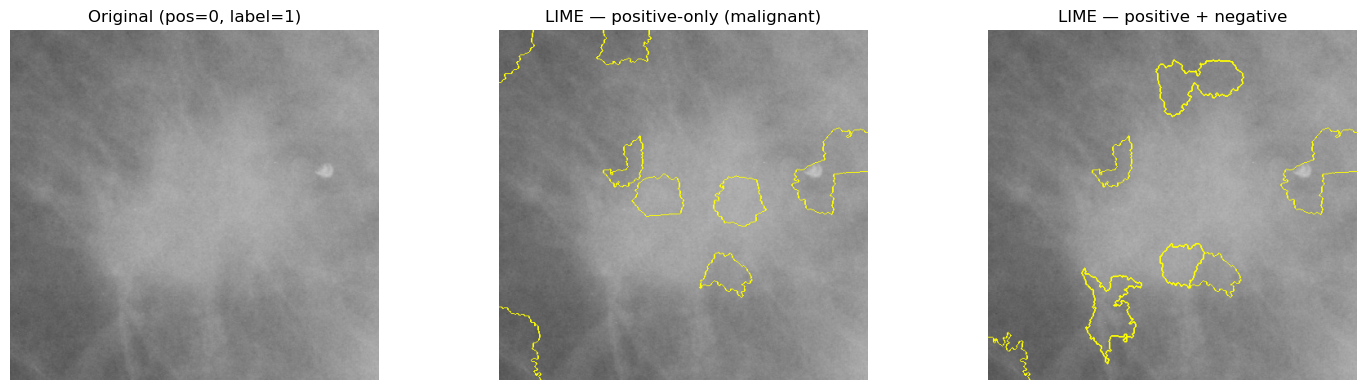

100%|██████████| 1000/1000 [00:29<00:00, 34.37it/s]


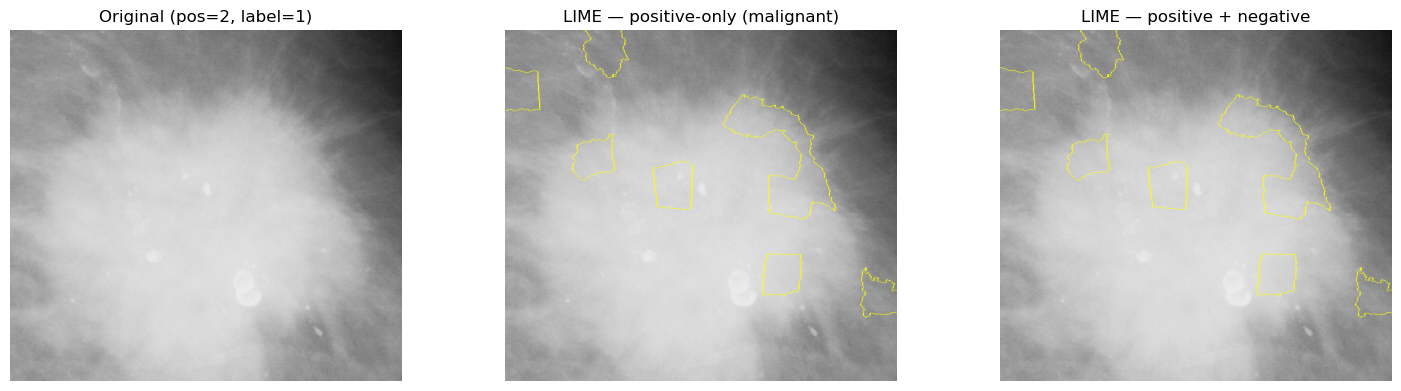

In [12]:
# ===========================================
# Cell 12 — LIME Image Explanations (2 samples) — improved visibility
# ===========================================
from skimage.segmentation import slic, mark_boundaries
from lime import lime_image

explainer_lime = lime_image.LimeImageExplainer()

for pos in chosen_pos:  # use POSITIONS, not labels
    raw, row = load_raw_rgb_from_idx(pos)
    predict_fn = make_lime_predict_fn(row, model_best)

    explanation = explainer_lime.explain_instance(
        raw,
        predict_fn,
        top_labels=2,
        hide_color=0,
        num_samples=1000,
        segmentation_fn=lambda x: slic(x, n_segments=100, compactness=10, sigma=1)
    )

    # Positive-only (malignant-supporting regions)
    _, mask_pos = explanation.get_image_and_mask(
        label=1, positive_only=True, num_features=10, hide_rest=False
    )
    # Positive + negative
    _, mask_both = explanation.get_image_and_mask(
        label=1, positive_only=False, num_features=10, hide_rest=False
    )

    img01 = raw.astype(np.float32) / 255.0  # mark_boundaries expects [0,1]

    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    plt.title(f"Original (pos={int(pos)}, label={int(row['label'])})")
    plt.imshow(raw); plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("LIME — positive-only (malignant)")
    plt.imshow(mark_boundaries(img01, mask_pos)); plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("LIME — positive + negative")
    plt.imshow(mark_boundaries(img01, mask_both)); plt.axis("off")

    plt.tight_layout(); plt.show()


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


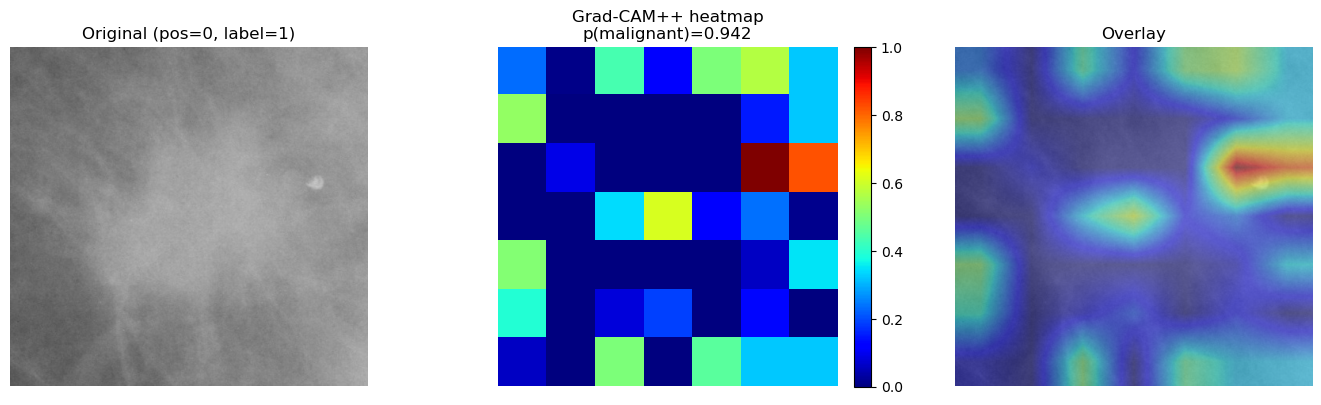

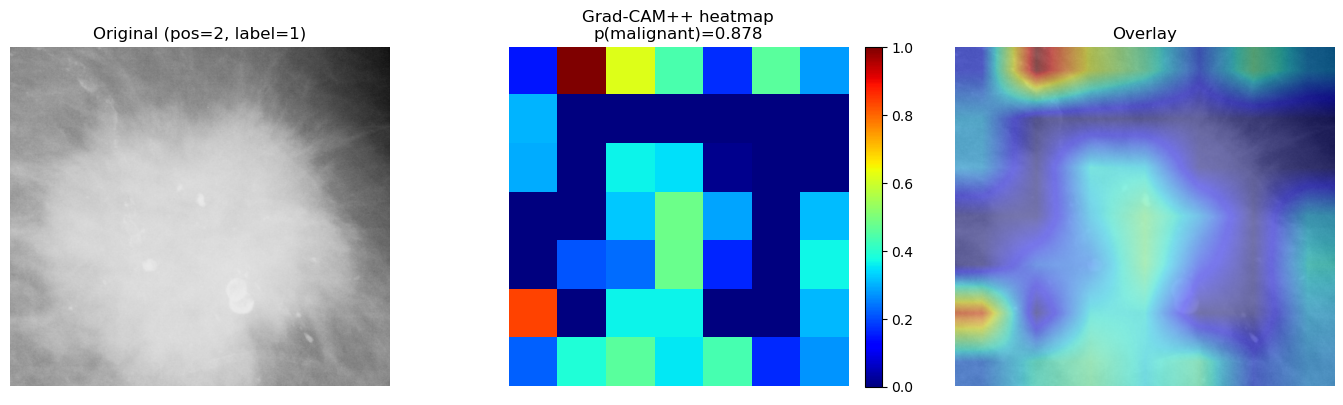

In [13]:
# ===========================================
# Cell 13 — Grad-CAM++ for MaxViTTinyWithMeta 
# ===========================================
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

@torch.no_grad()
def _to_rgb01(u8):
    return (u8.astype(np.float32) / 255.0).clip(0, 1)

def overlay_cam_on_image(raw_uint8, cam_01, alpha=0.45, cmap_name="jet"):
    h, w = raw_uint8.shape[:2]
    if cam_01.shape[:2] != (h, w):
        cam_01 = cv2.resize(cam_01, (w, h))
    heatmap = cm.get_cmap(cmap_name)(cam_01)[..., :3]      # RGB in [0,1]
    return np.clip((1 - alpha) * _to_rgb01(raw_uint8) + alpha * heatmap, 0, 1)

def gradcampp_from_features(A, dY, eps=1e-8):
    """
    A: (1,C,H,W) activations from base.forward_features(x) with grad
    dY: d(logit)/dA  (1,C,H,W)
    returns: (H,W) CAM in [0,1]
    """
    dY2 = dY ** 2
    dY3 = dY ** 3
    sumA = torch.sum(A, dim=(2,3), keepdim=True)                 # (1,C,1,1)
    alpha = dY2 / (2.0 * dY2 + sumA * dY3 + eps)                 # (1,C,H,W)
    weights = torch.sum(alpha * F.relu(dY), dim=(2,3))           # (1,C)
    cam = torch.sum(weights[:, :, None, None] * A, dim=1)        # (1,H,W)
    cam = F.relu(cam)
    cam -= cam.min()
    cam /= (cam.max() + eps)
    return cam[0].detach().cpu().numpy()

def gradcampp_maxvit_with_meta(model_with_meta, x, meta):
    """
    model_with_meta: MaxViTTinyWithMeta
    x:    (1,3,H,W) normalized, on DEVICE
    meta: (1,4)     on DEVICE
    returns: (cam_01, p_malignant)
    """
    model_with_meta.eval()

    # 1) Last spatial feature map (requires grad)
    x = x.requires_grad_(True)
    A = model_with_meta.base.forward_features(x)    # (1,C,H,W)
    A.retain_grad()

    # 2) Get pooled features EXACTLY as timm would (no calling a string attr)
    if hasattr(model_with_meta.base, "forward_head"):
        # pre_logits=True gives the pooled vector before classifier
        pooled = model_with_meta.base.forward_head(A, pre_logits=True)  # (1,C)
    else:
        # Fallback: global average pool
        pooled = F.adaptive_avg_pool2d(A, 1).flatten(1)                 # (1,C)

    fused  = torch.cat([pooled, meta], dim=1)       # (1,C+4)
    logit  = model_with_meta.head(fused)            # (1,1)
    p      = torch.sigmoid(logit)[0,0]

    # 3) Backprop wrt A
    model_with_meta.zero_grad(set_to_none=True)
    logit.backward(retain_graph=False)

    if A.grad is None:
        raise RuntimeError("A.grad is None — ensure no torch.no_grad() wraps this call and x.requires_grad_(True).")

    # 4) Build CAM++
    cam = gradcampp_from_features(A, A.grad)        # (H,W) in [0,1]
    return cam, float(p.item())

# ---- Run on the same two validation positions we used for LIME ----
for pos in chosen_pos:
    raw, row = load_raw_rgb_from_idx(pos)                           # uint8 HxWx3
    x = preprocess_to_tensor(raw).unsqueeze(0).to(DEVICE)           # (1,3,H,W)
    meta_fixed = meta_from_row(row).to(DEVICE).unsqueeze(0)         # (1,4)

    cam, p_malignant = gradcampp_maxvit_with_meta(model_best, x, meta_fixed)
    overlay = overlay_cam_on_image(raw, cam, alpha=0.45, cmap_name="jet")

    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1); plt.title(f"Original (pos={int(pos)}, label={int(row['label'])})")
    plt.imshow(raw); plt.axis("off")

    plt.subplot(1,3,2); plt.title(f"Grad-CAM++ heatmap\np(malignant)={p_malignant:.3f}")
    im = plt.imshow(cam, cmap="jet", vmin=0.0, vmax=1.0)
    plt.colorbar(im, fraction=0.046, pad=0.04); plt.axis("off")

    plt.subplot(1,3,3); plt.title("Overlay")
    plt.imshow(overlay); plt.axis("off")
    plt.tight_layout(); plt.show()
